In [1]:
import itertools

from tf.app import use
A = use('etcbc/bhsa', hoist=globals())

from nltk import bigrams
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

from datasets import Dataset, DatasetDict

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,39,10938.21,100
chapter,929,459.19,100
lex,9230,46.22,100
verse,23213,18.38,100
half_verse,45179,9.44,100
sentence,63717,6.70,100
sentence_atom,64514,6.61,100
clause,88131,4.84,100
clause_atom,90704,4.70,100
phrase,253203,1.68,100


In [1]:
import torch
torch.cuda.empty_cache() 

In [2]:
def make_n_grams(input_list, n):
  return zip(*[input_list[i:] for i in range(n)])

def make_n_clause_dict(n):
    """
    Makes sequences of n clauses in the Hebrew Bible, based on a running window.
    """
    n_clause_dict = {}

    for bo in F.otype.s('book'):
        cl_n_grams = list(make_n_grams(L.d(bo, 'clause'), n))
        
        for cl_n_gram in cl_n_grams:
            ch = L.u(cl_n_gram[0], 'chapter')[0]
            book, chapter_number = T.sectionFromNode(ch)
            
            words_n_clause = sorted(list(itertools.chain(*[L.d(cl, 'word') for cl in cl_n_gram])))
            heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in words_n_clause]).strip()
            n_clause_dict[(book, chapter_number, cl_n_gram)] = [book, chapter_number, cl_n_gram, heb_text]

    return n_clause_dict

In [3]:
n_clause_dict = make_n_clause_dict(3)

bib_df = pd.DataFrame(n_clause_dict).T
bib_df.columns = ['book', 'chapter', 'clauses', 'text']
bib_df.head()

NameError: name 'F' is not defined

In [5]:
bib_ds = Dataset.from_pandas(bib_df)

In [6]:
tokenizer = AutoTokenizer.from_pretrained('dicta-il/BEREL')

In [7]:
def tokenize(sentence):
  return tokenizer(sentence['text'], max_length=128, truncation=True, padding=True)

tokenized_data = bib_ds.map(tokenize, batched=True) #, remove_columns=raw_data['train'].column_names)
tokenized_data.set_format("pt", columns=["input_ids", "attention_mask"], output_all_columns=True)

tokenized_data = tokenized_data.train_test_split(test_size=0.2)

Map:   0%|          | 0/88053 [00:00<?, ? examples/s]

In [8]:
model = BertForMaskedLM.from_pretrained('dicta-il/BEREL', output_hidden_states=True)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
C:\Users\geitb\anaconda3\envs\huggingface\lib\site-packages\transformers\generation\configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to

In [8]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=True, mlm_probability=.15)

In [11]:
args = TrainingArguments(output_dir="martijn75/berel_finetuned_on_HB_8_epochs_general", 
                         evaluation_strategy="steps",
                         save_strategy="epoch",
                         learning_rate=0.0001,
                         num_train_epochs=8,
                         per_device_train_batch_size=8, 
                         per_device_eval_batch_size=8,
                         seed=42,
                        )
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
  )

trainer.train()

trainer.push_to_hub()

C:\Users\geitb\anaconda3\envs\huggingface\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\geitb\AppData\Local\Temp\ipykernel_16732\2424402536.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
500,3.305100,2.970886
1000,3.294400,2.950040
1500,3.231100,2.933302
2000,3.337300,2.990496
2500,3.325100,2.991597
3000,3.274300,3.007938
3500,3.328300,2.960625
4000,3.249200,2.950302
4500,3.179200,2.920418
5000,3.258500,2.924102


training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/martijn75/berel_finetuned_on_HB_8_epochs_general/commit/36995ed1ccd56c2b535d01fe2e1fab2232302e2c', commit_message='End of training', commit_description='', oid='36995ed1ccd56c2b535d01fe2e1fab2232302e2c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/martijn75/berel_finetuned_on_HB_8_epochs_general', endpoint='https://huggingface.co', repo_type='model', repo_id='martijn75/berel_finetuned_on_HB_8_epochs_general'), pr_revision=None, pr_num=None)

In [9]:
prose = {
    'Genesis',
    'Exodus',
    'Leviticus',
    'Numbers',
    'Deuteronomy',
    'Joshua',
    'Judges',
    '1_Samuel',
    '2_Samuel',
    '1_Kings',
    '2_Kings',
    'Ruth',
    'Esther',
    'Daniel',
    'Ezra',
    'Nehemiah',
    '1_Chronicles',
    '2_Chronicles'
        }

poetry = {
    'Psalms',
    'Job',
    'Proverbs',
    'Song_of_songs',
    'Ecclesiastes',
    'Lamentations'
}

jeremiah = {'Jeremiah'}

genre_dict = {}
for book in prose:
    genre_dict[book] = 'prose'
for book in poetry:
    genre_dict[book] = 'poetry'

genre_dict['Jeremiah'] = 'Jeremiah'

In [10]:
def get_last_hidden_state(model, inputs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #'cpu' 
    model = model.to(device)
    outputs = model(**inputs)
    return outputs

In [11]:
def split_evenly(l, n):
    len_ = len(l)
    split_size = len_ // n
    split_size = n if not split_size else split_size
    offsets = [i for i in range(0, len_, split_size)]
    return [l[offset:offset + split_size] for offset in offsets]

In [12]:
heb_texts = list(n_clause_dict.values())
heb_texts_n = split_evenly(heb_texts, 1000)

In [13]:
len(heb_texts_n)

1001

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#tokenizer = AutoTokenizer.from_pretrained('dicta-il/BEREL')
#model = BertForMaskedLM.from_pretrained('dicta-il/BEREL', output_hidden_states=True).to(device)

model = BertForMaskedLM.from_pretrained('martijn75/berel_finetuned_on_HB_2_epochs_general', 
                                                           ).to(device)
model.eval()

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
C:\Users\geitb\anaconda3\envs\huggingface\lib\site-packages\transformers\generation\configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [15]:
hidden_states = []

for idx, texts_chunk_data in enumerate(heb_texts_n):
    text_chunks = [text_ch for _,_,_,text_ch in texts_chunk_data]
    tokenized_inputs = tokenizer(text_chunks, max_length=128, truncation=True, padding=True, return_tensors="pt")
    tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}
    with torch.no_grad():
        outputs = get_last_hidden_state(model, tokenized_inputs)
        last_hidden_states = outputs.hidden_states[-1].cpu().numpy()
        hidden_states.append(last_hidden_states)

In [16]:
hidden_states_mean = []

for hs in hidden_states:

    bi_clause_states= np.mean(hs, 1)
    hidden_states_mean.append(bi_clause_states)

all_embeddings = np.concatenate(hidden_states_mean, axis=0)

In [17]:
all_genres = []
all_labels = []

for bo, ch, clauses in n_clause_dict.keys():
    all_genres.append(bo)
    all_labels.append((bo, clauses))

In [18]:
print(len(all_genres), len(all_embeddings))

88053 88053


### PCA

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA, FastICA, NMF, FactorAnalysis

In [20]:
random_state = 0
pca_pl = make_pipeline(
    StandardScaler(),
    PCA(n_components = 6,
        random_state = random_state)
)

In [21]:
pcs = pca_pl.fit_transform(all_embeddings)

In [22]:
pcs

array([[ 8.140341  , -6.4931736 , -1.8979944 , -5.95727   , -0.4954209 ,
        -1.4272954 ],
       [ 8.660101  , -6.918027  , -2.0351124 , -5.9062204 , -0.11909167,
         0.01497757],
       [ 8.69895   , -6.890566  , -2.431689  , -6.7813535 ,  0.71401614,
         0.16543637],
       ...,
       [ 8.290737  ,  3.0772014 , -4.8337326 , -1.1674107 , -4.5091977 ,
        -1.9931908 ],
       [ 7.8119617 ,  3.366506  , -4.4890976 , -0.9168679 , -5.173474  ,
        -2.0823247 ],
       [ 7.5769567 ,  3.5562437 , -4.306814  , -0.77295744, -5.9138002 ,
        -3.0311756 ]], dtype=float32)

In [26]:
book = 'Genesis'
y = np.array([1 if bo == book else 0 for bo in all_genres])
y.sum()

5985

In [27]:
pcs_df = pd.DataFrame(data = pcs , 
        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
pcs_df['label'] = y



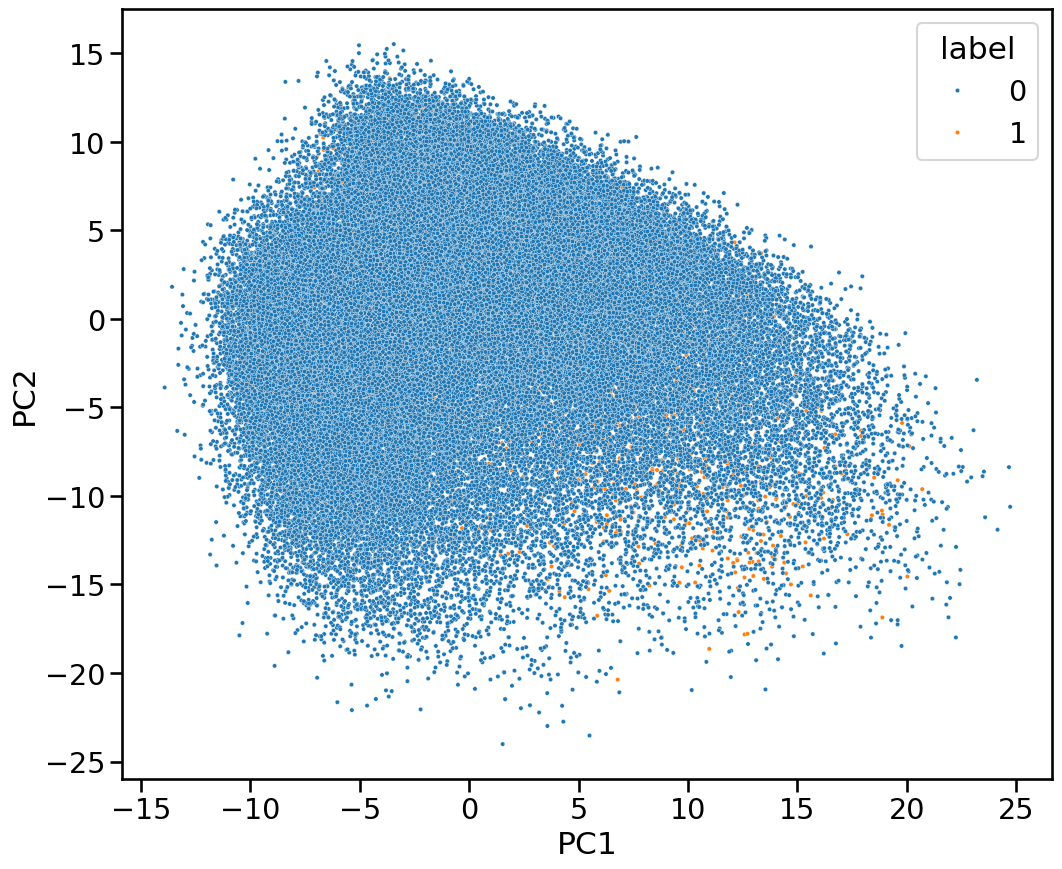

In [28]:
comp1 = 'PC1'
comp2 = 'PC2'


pcs_df = pd.DataFrame(data = pcs , 
        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
pcs_df['label'] = y
#pcs_df['book'] = _labels

plt.figure(figsize=(12,10))
with sns.plotting_context("talk",font_scale=1.25):
    sns.scatterplot(x=comp1, y=comp2,
                    data=pcs_df, 
                    hue="label",
                    s=10)
    plt.xlabel(comp1)
    plt.ylabel(comp2)
   
#plt.savefig("pca_chb_lbh_jer.png",
#                    format='png',dpi=150)

In [141]:
nm_ptc_clauses = []

# cl_types = {'AjCl', 'NmCl', 'Ptcp'}

for cl in F.otype.s('clause'):
    #cl_type = F.typ.v(cl)
    phrase_funcs = [F.function.v(phr) for phr in L.d(cl, 'phrase')]
    #if not ('PreC' in phrase_funcs and 'Subj' in phrase_funcs):
    #    continue
    #if cl_type in cl_types:
    heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in L.d(cl, 'word')]).strip()
    nm_ptc_clauses.append(heb_text)
    #print(heb_text)

len(nm_ptc_clauses)

88131

In [142]:
new_clauses = """
 דוד מלך
דוד היה מלך
היה דוד מלך

משׁה מלך
משׁה היה מלך
היה משׁה מלך

דוד בירושׁלים
דוד היה בירושׁלים
היה דוד בירושׁלים

דוד ישׁב בירושׁלים
ישׁב דוד בירושׁלים

דוד יושׁב בירושׁלים
יושׁב דוד בירושׁלים
 """

In [143]:
new_clauses = [cl.strip() for cl in new_clauses.split('\n') if cl.strip()]
new_clauses

['דוד מלך',
 'דוד היה מלך',
 'היה דוד מלך',
 'משׁה מלך',
 'משׁה היה מלך',
 'היה משׁה מלך',
 'דוד בירושׁלים',
 'דוד היה בירושׁלים',
 'היה דוד בירושׁלים',
 'דוד ישׁב בירושׁלים',
 'ישׁב דוד בירושׁלים',
 'דוד יושׁב בירושׁלים',
 'יושׁב דוד בירושׁלים']

In [144]:
all_nom_clauses = new_clauses + nm_ptc_clauses
all_nom_clauses_n = split_evenly(all_nom_clauses, 1000)

In [145]:
labels = new_clauses + len(nm_ptc_clauses)*['']
all_texts = new_clauses + nm_ptc_clauses

In [146]:
hidden_states = []

for text_chunks in all_nom_clauses_n:
    
    tokenized_inputs = tokenizer(text_chunks, max_length=128, truncation=True, padding=True, return_tensors="pt")
    tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}
    with torch.no_grad():
        outputs = get_last_hidden_state(model, tokenized_inputs)
        last_hidden_states = outputs.hidden_states[-1].cpu().numpy()
        hidden_states.append(last_hidden_states)

In [147]:
print(len(hidden_states))

1002


In [148]:
hidden_states_mean = []

for hs in hidden_states:
    bi_clause_states= np.mean(hs, 1)
    hidden_states_mean.append(bi_clause_states)

all_new_embeddings = np.concatenate(hidden_states_mean, axis=0)

In [149]:
all_new_embeddings.shape

(88144, 768)

In [150]:
pcs = pca_pl.fit_transform(all_new_embeddings)

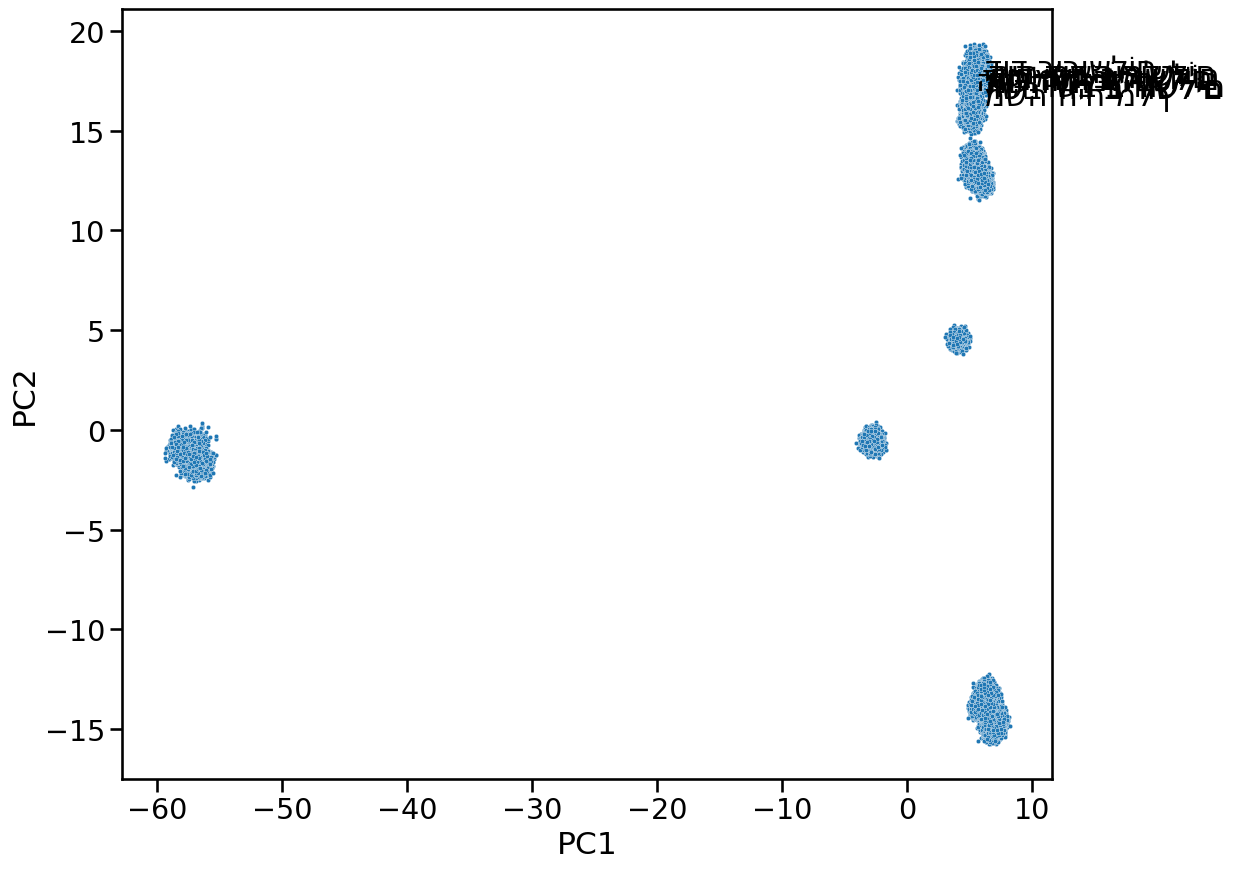

In [151]:
comp1 = 'PC1'
comp2 = 'PC2'

pcs_df = pd.DataFrame(data = pcs, 
        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
pcs_df['label'] = labels


plt.figure(figsize=(12,10))
with sns.plotting_context("talk",font_scale=1.25):
    ax = sns.scatterplot(x=comp1, y=comp2,
                    data=pcs_df, 
                    #hue="label",
                    s=10)
    plt.xlabel(comp1)
    plt.ylabel(comp2)

    for i, txt in enumerate(pcs_df['label']):
        ax.annotate(txt, (pcs_df.PC1[i], pcs_df.PC2[i]), xytext=(10,10), textcoords='offset points')
        

In [154]:


pcs_df2 = pcs_df.drop(['PC3', 'PC4', 'PC5', 'PC6', 'label'], axis=1)

new_emb = pcs_df2[:13]
other_emb = pcs_df2[13:]

In [155]:
from scipy.spatial.distance import euclidean



for idx, row1 in new_emb.iterrows():
    print(new_clauses[idx])
    distances = []
    for idx, row2 in other_emb.iterrows():
        dist = euclidean(row1, row2)
        distances.append(dist)

    
    close_ind = np.argpartition(distances, 10)[:10]
    

    far_ind = np.argpartition(distances, -10)[-10:]
    print([nm_ptc_clauses[idx] for idx in close_ind])
    print()
    print([nm_ptc_clauses[idx] for idx in far_ind])
    print()
    print()
    

דוד מלך
['ויאמר אליו', 'לכהן', 'ויאמר אליו', 'ויאמר אליו', 'די להוא באחרית יומיא', 'לכהן', 'למלכיאל משׁפחת המלכיאלי', 'ואמר', 'שׁלח על כל הגולה', 'ויקראו בני ראובן ובני גד למזבח']

['ויעמד פתח האהל', 'ואת כל משׁפחותיה הוציאו', 'כל זכר יאכל אתו', 'והאישׁ משׁה ענו מאד מכל האדם', 'נעמת לי מאד', 'לבער', 'אתם ראיתם', 'אמתים וחצי ארכה', 'ואמרת אלהם', 'ועבדתם שׁם את אלהים אחרים יומם ולילה']


דוד היה מלך
['ונטעתיו', 'די כל מתנדב במלכותי מן עמה ישׂראל וכהנוהי ולויא עמך יהך', 'בעצם היום הזה נמול אברהם וישׁמעאל בנו', 'הנשׁבעים ליהוה', 'ולא ילמדו עוד', 'אז יתן המלך שׁלמה לחירם עשׂרים עיר בארץ הגליל', 'וישׂימה תל עולם שׁממה עד היום הזה', 'ויאמר יהוה לו עוד', 'אלה משׁפחת בני גד לפקדיהם ארבעים אלף וחמשׁ מאות', 'לא ישׂברו יורדי בור אל אמתך']

['ויעמד פתח האהל', 'לבער', 'נעמת לי מאד', 'אמתים וחצי ארכה', 'כל זכר יאכל אתו', 'ועבדתם שׁם את אלהים אחרים יומם ולילה', 'והאישׁ משׁה ענו מאד מכל האדם', 'ואת כל משׁפחותיה הוציאו', 'ואמרת אלהם', 'אתם ראיתם']


היה דוד מלך
['מארץ רחוקה באו מבבל', 'למה לנצח תשׁכחנו'

In [156]:
text = new_clauses[0]

tokenized_inputs = tokenizer(text, max_length=128, truncation=True, padding=True, return_tensors="pt")
tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}
#with torch.no_grad():
outputs = get_last_hidden_state(model, tokenized_inputs)
    #last_hidden_states = outputs.hidden_states[-1].cpu().numpy()


In [157]:
dir(outputs)

['__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'attentions',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'hidden_states',
 'items',
 'keys',
 'logits',
 'loss',
 'move_to_end',
 'pop',
 'popitem',
 'setdefault',
 'to_tuple',
 'update',
 'values']

In [160]:
len(outputs.hidden_states)

13

In [161]:
outputs.hidden_states

(tensor([[[-1.4901e-04,  2.9298e-03, -6.6191e-03,  ...,  8.5600e-03,
            3.1179e-03,  9.0653e-03],
          [-1.7665e-01,  1.1826e-01,  8.7172e-02,  ..., -6.4585e-02,
           -1.5114e-01,  1.3979e-03],
          [-4.2313e-03,  1.1677e-01,  1.8565e-02,  ..., -5.7737e-03,
           -1.1372e-01,  1.4453e-01],
          [-4.3244e-02, -1.0374e-01, -5.6593e-02,  ...,  1.4429e-02,
           -1.0905e-01,  3.0668e-02]]], device='cuda:0',
        grad_fn=<NativeLayerNormBackward0>),
 tensor([[[-6.4607e-03, -1.8605e-02, -8.7636e-03,  ..., -9.8619e-03,
            3.9772e-03,  3.7115e-05],
          [-3.0677e-01,  8.9067e-03,  1.9642e-01,  ..., -1.1118e-01,
           -1.2430e-01, -3.1956e-02],
          [-1.2397e-01, -2.5631e-02, -3.3537e-02,  ...,  6.9892e-03,
           -2.0270e-01,  8.0047e-02],
          [-5.9386e-02, -8.0686e-02, -4.4012e-02,  ..., -5.3065e-02,
           -8.7297e-02, -5.5159e-03]]], device='cuda:0',
        grad_fn=<NativeLayerNormBackward0>),
 tensor([[[-0.04

In [172]:
outputs

MaskedLMOutput(loss=None, logits=tensor([[[-12.9358, -25.5464, -11.2973,  ..., -13.0541,  -6.9932, -12.9664],
         [-12.9358, -25.5464, -11.2973,  ..., -13.0541,  -6.9932, -12.9664],
         [-12.9358, -25.5464, -11.2973,  ..., -13.0541,  -6.9932, -12.9664],
         [-12.9358, -25.5464, -11.2973,  ..., -13.0541,  -6.9932, -12.9664]]],
       device='cuda:0', grad_fn=<ViewBackward0>), hidden_states=(tensor([[[-1.4901e-04,  2.9298e-03, -6.6191e-03,  ...,  8.5600e-03,
           3.1179e-03,  9.0653e-03],
         [-1.7665e-01,  1.1826e-01,  8.7172e-02,  ..., -6.4585e-02,
          -1.5114e-01,  1.3979e-03],
         [-4.2313e-03,  1.1677e-01,  1.8565e-02,  ..., -5.7737e-03,
          -1.1372e-01,  1.4453e-01],
         [-4.3244e-02, -1.0374e-01, -5.6593e-02,  ...,  1.4429e-02,
          -1.0905e-01,  3.0668e-02]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>), tensor([[[-6.4607e-03, -1.8605e-02, -8.7636e-03,  ..., -9.8619e-03,
           3.9772e-03,  3.7115e-05],
    

In [163]:
outputs.hidden_states[0].shape

torch.Size([1, 4, 768])

In [164]:
for state in outputs.hidden_states:
    print(state.shape)

torch.Size([1, 4, 768])
torch.Size([1, 4, 768])
torch.Size([1, 4, 768])
torch.Size([1, 4, 768])
torch.Size([1, 4, 768])
torch.Size([1, 4, 768])
torch.Size([1, 4, 768])
torch.Size([1, 4, 768])
torch.Size([1, 4, 768])
torch.Size([1, 4, 768])
torch.Size([1, 4, 768])
torch.Size([1, 4, 768])
torch.Size([1, 4, 768])


In [167]:
outputs.values()

odict_values([tensor([[[-12.9358, -25.5464, -11.2973,  ..., -13.0541,  -6.9932, -12.9664],
         [-12.9358, -25.5464, -11.2973,  ..., -13.0541,  -6.9932, -12.9664],
         [-12.9358, -25.5464, -11.2973,  ..., -13.0541,  -6.9932, -12.9664],
         [-12.9358, -25.5464, -11.2973,  ..., -13.0541,  -6.9932, -12.9664]]],
       device='cuda:0', grad_fn=<ViewBackward0>), (tensor([[[-1.4901e-04,  2.9298e-03, -6.6191e-03,  ...,  8.5600e-03,
           3.1179e-03,  9.0653e-03],
         [-1.7665e-01,  1.1826e-01,  8.7172e-02,  ..., -6.4585e-02,
          -1.5114e-01,  1.3979e-03],
         [-4.2313e-03,  1.1677e-01,  1.8565e-02,  ..., -5.7737e-03,
          -1.1372e-01,  1.4453e-01],
         [-4.3244e-02, -1.0374e-01, -5.6593e-02,  ...,  1.4429e-02,
          -1.0905e-01,  3.0668e-02]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>), tensor([[[-6.4607e-03, -1.8605e-02, -8.7636e-03,  ..., -9.8619e-03,
           3.9772e-03,  3.7115e-05],
         [-3.0677e-01,  8.9067e-03,  